#### NX-414: Brain-like computation and intelligence
##### TA: Alessandro Marin Vargas

# Week 7 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2024

You are required to submit your mini-projects by midnight on 07/05/24. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

In [1]:
import sys
sys.path.append('./../')
!{sys.executable} -m pip install gdown h5py

In [12]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=b2a7e4ae-3d2b-4ba4-8e45-6ad29d494e03
To: /home/jupyter/Brain_like_mini_project/IT_data.h5
100%|██████████| 384M/384M [00:05<00:00, 72.6MB/s] 


'IT_data.h5'

### Load the data

In [13]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [14]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


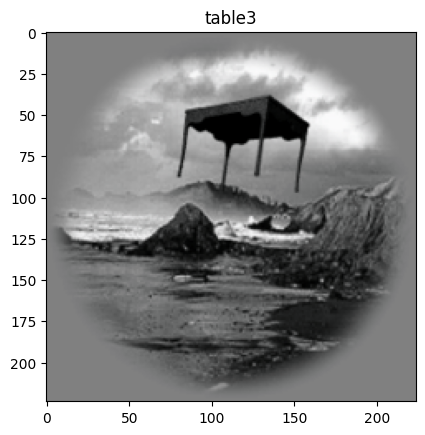

In [15]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

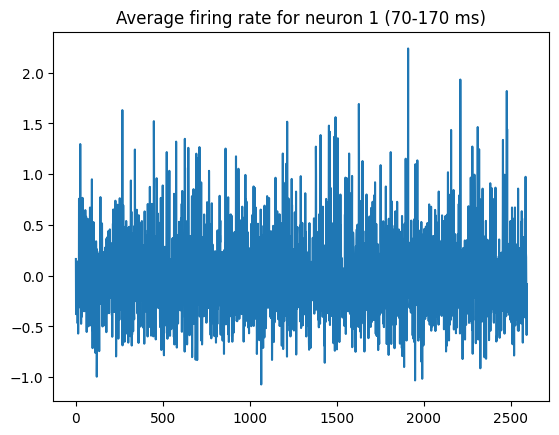

In [16]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

## Predict the neural activity using a data-driven approach

In the first part of the project, you have predicted the neural activity either from pixels or from the activations of a pre-trained neural network model. Here, your objective is to build and train a shallow convolutional neural network to predict the IT neural activity.

Follow these steps:
- Create the dataloader
- Define the model (Shallow CNN with 2/3 layers)
- Define the loss function (MSE) and the optimizer
- Build the training script and train your model
- Evaluate the predictions of your model. 
- Compare the neural predictions with the ones achieved by the task-trained neural network model. Which one can better predict the neural activity?

In [17]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import pandas as pd

#### Create the dataloader

In [18]:
class Dataset(Dataset):
    def __init__(self, stim, spi):
        self.features = stim
        self.target = spi

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        X = self.features[idx]
        y = self.target[idx]

        return X, y
    
# Initialize the dataset and loader
batch_size = 128

training_data = Dataset(stimulus_train, spikes_train) 
val_data = Dataset(stimulus_val, spikes_val) 

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=stimulus_val.shape[0], shuffle=False)

#### Define the model

In [19]:
def he_init(layer):
    '''
    Variance-preserving initialization of weights for one layer.

    Args:
        layer (torch.nn.Module): layer to initialize
    '''
    
    if isinstance(layer, nn.Conv2d):
        nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')

In [20]:
class IT_CNN(nn.Module):
    def __init__(self, features_in, features_out):
        super(IT_CNN, self).__init__()
        
        # Layer 1
        self.conv1 = nn.Conv2d(in_channels=features_in, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(num_features=128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Linear layer 1
        self.fc1 = nn.Linear(in_features=128*26*26, out_features=256) # in_features checked using torchinfo.summarynon fully CNN
        self.relu = nn.ReLU()
        
        # Linear layer 2
        self.fc2 = nn.Linear(in_features=256, out_features=168) 
        
        self.apply(he_init)
        
    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x)))) # conv 1
        x = self.pool2(self.relu2(self.bn2(self.conv2(x)))) # conv 2
        x = self.pool3(self.relu3(self.bn3(self.conv3(x)))) # conv 3

        x = self.relu(self.fc1(x.view(x.size(0), -1))) # linear 1
        x = self.fc2(x) # linear 2
        
        return x

In [21]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Set a random seed (reproducibility)

In [23]:
def set_random_seeds(seed=12):
    # Set seed for NumPy
    np.random.seed(seed)

    # Set seed for PyTorch on CPU
    torch.manual_seed(seed)

    # Set seed for PyTorch on GPU (if available)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_random_seeds()

#### Hyperparameter tunning with optuna = grid search 

In [24]:
pip install optuna 

Note: you may need to restart the kernel to use updated packages.


In [25]:
import optuna 

In [26]:
# Parameters for Optuna
n_trials = 15 
num_epochs = 10

In [27]:
def objective(trial, train_loader_hyp, val_loader_hyp, num_epochs, device):
    '''
    Objective function to be optimized by tuning the hyperparameters, here, the F1 score

    Args:
        trial (optuna.trial): trial
        train_loader_hyp (torch.utils.data.DataLoader): training set for hyperparameter tuning
        val_loader_hyp (torch.utils.data.DataLoader): validation set for hyperparameter tuning
        num_epochs (int): number of epochs

    Returns:
        Explained variance 

    Note: The training and validation sets for hyperparameter tuning make up the validation set.
    '''

    # Generate the model
    model_optuna = IT_CNN(features_in = 3, features_out = 168)
    model_optuna = model_optuna.cuda()
    
    # Generate the optimizers for: the optimizer, the criterion, and the learning rate scheduler
    weight_decay = trial.suggest_float('weight_decay', 1e-4, 1e-1, log=True)
    lr = trial.suggest_float('lr', 1e-7, 1e-4, log=True)
    optimizer = torch.optim.AdamW(model_optuna.parameters(), lr=lr, weight_decay=weight_decay) #, betas=(beta1, beta2))

    criterion = nn.MSELoss()
    
    scheduler_name = trial.suggest_categorical('scheduler', ['StepLR', 'CosineAnnealingLR'])
    if scheduler_name == 'StepLR':
        step_size = trial.suggest_float('step_size', 5, 10)
        gamma = trial.suggest_float('gamma', 1e-10, 1e-1, log=True)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_name == 'CosineAnnealingLR':
        eta_min = trial.suggest_float('eta_min', 1e-10, 1e-5, log=True)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=(len(train_loader_hyp.dataset) * num_epochs) // train_loader_hyp.batch_size,
            eta_min=eta_min
        )
    
    
    # Train and validate the model
    print("Start train and validate with optuna")
    for epoch in range(1, num_epochs + 1):
        print("Epoch: ", epoch)
        for batch_x, batch_y in train_loader_hyp :
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            model_optuna.train()
            
            # Forward pass
            optimizer.zero_grad()
            output = model_optuna(batch_x)

            # Compute the gradient
            loss = criterion(output,batch_y)
            loss.backward()

            # Update the parameters of the model with a gradient step
            optimizer.step()
            scheduler.step()

        model_optuna.eval()
        
        evs = []        
        for batch_xval, batch_yval in val_loader_hyp :
            batch_xval = batch_xval.to(device)
        
            y_pred = model_optuna(batch_xval)
            y_pred = y_pred.cpu().detach().numpy()
            
            for i in range(batch_yval.shape[1]):
                # Explained variance
                ev = explained_variance_score(batch_yval[:, i], y_pred[:, i])
                evs.append(ev)
        
        EV= np.mean(evs)
        
        # Pruning
        trial.report(EV, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return EV

In [28]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, train_dataloader, val_dataloader, num_epochs, device), n_trials=n_trials)
    
pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])

# Save the best trial
trial = study.best_trial
param = {}
for key, value in trial.params.items():
    param[key] = value
best_params = {'Best ev': trial.value, 'Param': param}

[I 2024-05-06 16:02:18,457] A new study created in memory with name: no-name-a06acf0a-e29c-43cb-8486-69c7bda4934d


Start train and validate with optuna
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10


[I 2024-05-06 16:03:21,973] Trial 0 finished with value: 0.0016825003992943536 and parameters: {'weight_decay': 0.05469368548561769, 'lr': 3.265786929308846e-05, 'scheduler': 'StepLR', 'step_size': 5.792910108432278, 'gamma': 0.001552526688234513}. Best is trial 0 with value: 0.0016825003992943536.


Start train and validate with optuna
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10


[I 2024-05-06 16:04:22,757] Trial 1 finished with value: -1.064368656703404e-09 and parameters: {'weight_decay': 0.04386538678295093, 'lr': 5.134603587065216e-05, 'scheduler': 'StepLR', 'step_size': 8.2227749428956, 'gamma': 1.8194680333485585e-09}. Best is trial 0 with value: 0.0016825003992943536.


Start train and validate with optuna
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10


[I 2024-05-06 16:05:24,375] Trial 2 finished with value: -0.003893956896804628 and parameters: {'weight_decay': 0.09397721961858521, 'lr': 5.666584623036955e-07, 'scheduler': 'StepLR', 'step_size': 8.637700426482638, 'gamma': 1.1860318674430973e-10}. Best is trial 0 with value: 0.0016825003992943536.


Start train and validate with optuna
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10


[I 2024-05-06 16:06:26,021] Trial 3 finished with value: -0.002646846430642264 and parameters: {'weight_decay': 0.003918344052079535, 'lr': 2.6547063910044242e-06, 'scheduler': 'CosineAnnealingLR', 'eta_min': 1.3098160647854143e-08}. Best is trial 0 with value: 0.0016825003992943536.


Start train and validate with optuna
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10


[I 2024-05-06 16:07:27,586] Trial 4 finished with value: 0.004445360529990424 and parameters: {'weight_decay': 0.00011655219460285894, 'lr': 2.198620521535237e-05, 'scheduler': 'StepLR', 'step_size': 9.370055586761737, 'gamma': 1.657658383628407e-08}. Best is trial 4 with value: 0.004445360529990424.


Start train and validate with optuna
Epoch:  1


[I 2024-05-06 16:07:33,892] Trial 5 pruned. 


Start train and validate with optuna
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10


[I 2024-05-06 16:08:34,590] Trial 6 finished with value: -4.612264179048084e-09 and parameters: {'weight_decay': 0.0004308459730135017, 'lr': 9.191257133504888e-05, 'scheduler': 'StepLR', 'step_size': 5.050611765746192, 'gamma': 2.992747703404151e-08}. Best is trial 4 with value: 0.004445360529990424.


Start train and validate with optuna
Epoch:  1


[I 2024-05-06 16:08:40,921] Trial 7 pruned. 


Start train and validate with optuna
Epoch:  1


[I 2024-05-06 16:08:47,241] Trial 8 pruned. 


Start train and validate with optuna
Epoch:  1


[I 2024-05-06 16:08:53,558] Trial 9 pruned. 


Start train and validate with optuna
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10


[I 2024-05-06 16:09:55,172] Trial 10 finished with value: 0.0059063005305471875 and parameters: {'weight_decay': 0.001816647658413899, 'lr': 1.0945681119704392e-05, 'scheduler': 'CosineAnnealingLR', 'eta_min': 1.4262927221857e-10}. Best is trial 10 with value: 0.0059063005305471875.


Start train and validate with optuna
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10


[I 2024-05-06 16:10:56,813] Trial 11 finished with value: 0.0046336523124149865 and parameters: {'weight_decay': 0.0015499247055509497, 'lr': 1.0806066050111733e-05, 'scheduler': 'CosineAnnealingLR', 'eta_min': 1.390795658423849e-10}. Best is trial 10 with value: 0.0059063005305471875.


Start train and validate with optuna
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10


[I 2024-05-06 16:11:58,483] Trial 12 finished with value: 0.0019535376202492486 and parameters: {'weight_decay': 0.0017837597309497077, 'lr': 6.524068506355271e-06, 'scheduler': 'CosineAnnealingLR', 'eta_min': 1.1856322906022144e-10}. Best is trial 10 with value: 0.0059063005305471875.


Start train and validate with optuna
Epoch:  1


[I 2024-05-06 16:12:04,818] Trial 13 pruned. 


Start train and validate with optuna
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10


[I 2024-05-06 16:13:06,467] Trial 14 finished with value: 0.004652741054693858 and parameters: {'weight_decay': 0.007364618087973095, 'lr': 8.215323093567602e-06, 'scheduler': 'CosineAnnealingLR', 'eta_min': 2.5567629387788867e-09}. Best is trial 10 with value: 0.0059063005305471875.


In [29]:
params = best_params['Param']
print(best_params)

{'Best ev': 0.0059063005305471875, 'Param': {'weight_decay': 0.001816647658413899, 'lr': 1.0945681119704392e-05, 'scheduler': 'CosineAnnealingLR', 'eta_min': 1.4262927221857e-10}}


#### Build the training script and train your model

In [30]:
def train_epoch(model, optimizer, scheduler, criterion, train_dataloader, epoch):
    '''
    Train the model for one epoch

    Args:
        model (torch.nn.Module): model to train
        optimizer (torch.optim): optimizer
        scheduler (torch.optim.lr_scheduler): learning rate scheduler
        criterion (torch.nn.Module): loss function
        train_dataloader (torch.utils.data.DataLoader): training set
        epoch (int): current epoch

    Returns:
        loss_history (list): loss history of the epoch
    '''
    model.train()
    loss_history = []

    for batch_idx, (data,target) in enumerate(train_dataloader) :
        data = torch.Tensor(data).to(device)
        target = torch.Tensor(target).to(device)

        # Forward pass
        optimizer.zero_grad()
        output = model(data)

        # Compute the gradient
        loss = criterion(output,target)
        loss.backward()

        # Update the parameters of the model with a gradient step
        optimizer.step()
        scheduler.step()

        loss_history.append(loss.item())

        # Keep track of the training metrics
        print(
          f"Train Epoch: {epoch}-{batch_idx:03d} "
          f"batch_loss={loss.item():0.2e} "
        )

    return loss_history

In [32]:
train_loss_history = []
val_loss_history = []

model = IT_CNN(features_in = 3, features_out = 168)
model = model.to(device)

num_epochs = 10
optimizer = torch.optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay']) #, betas = (params['beta1'], params['beta2'])) # Optimizer

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=params['step_size'], gamma=params['gamma'])
scheduler =torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=(len(train_dataloader.dataset) * num_epochs) // train_dataloader.batch_size, eta_min=params['eta_min']) # Adjust the learinig rate

criterion = nn.MSELoss() # MSE loss

for epoch in range(1, num_epochs + 1):
    
    # Train
    train_loss = train_epoch(
        model, optimizer, scheduler, criterion, train_dataloader, epoch
    )
    train_loss_history.extend(train_loss)
    
    # Validate
    model.eval()
    with torch.no_grad():
        val_loss = []
        for batch_idx, (data, target) in enumerate(val_dataloader):
            data = torch.Tensor(data).to(device)
            target = torch.Tensor(target).to(device)
            
            output = model(data)
            val_loss.append(criterion(output, target))

        mean_val_loss = torch.mean(torch.Tensor(val_loss))
        val_loss_history.append(mean_val_loss)

    print(
          f"Train Epoch: {epoch} "
          f"val_loss={mean_val_loss:0.2e} "
        )

Train Epoch: 1-000 batch_loss=2.13e-01 
Train Epoch: 1-001 batch_loss=1.69e-01 
Train Epoch: 1-002 batch_loss=1.49e-01 
Train Epoch: 1-003 batch_loss=1.38e-01 
Train Epoch: 1-004 batch_loss=1.41e-01 
Train Epoch: 1-005 batch_loss=1.44e-01 
Train Epoch: 1-006 batch_loss=1.43e-01 
Train Epoch: 1-007 batch_loss=1.31e-01 
Train Epoch: 1-008 batch_loss=1.39e-01 
Train Epoch: 1-009 batch_loss=1.32e-01 
Train Epoch: 1-010 batch_loss=1.35e-01 
Train Epoch: 1-011 batch_loss=1.28e-01 
Train Epoch: 1-012 batch_loss=1.38e-01 
Train Epoch: 1-013 batch_loss=1.35e-01 
Train Epoch: 1-014 batch_loss=1.41e-01 
Train Epoch: 1-015 batch_loss=1.44e-01 
Train Epoch: 1-016 batch_loss=1.37e-01 
Train Epoch: 1-017 batch_loss=1.33e-01 
Train Epoch: 1-018 batch_loss=1.36e-01 
Train Epoch: 1-019 batch_loss=1.40e-01 
Train Epoch: 1-020 batch_loss=1.35e-01 
Train Epoch: 1 val_loss=1.42e-01 
Train Epoch: 2-000 batch_loss=1.35e-01 
Train Epoch: 2-001 batch_loss=1.29e-01 
Train Epoch: 2-002 batch_loss=1.29e-01 
Train 

In [44]:
# Save training outcomes and model
model_params = torch.save(model.state_dict(), 'c3l1.pth')
df_train = pd.DataFrame(train_loss_history)
df_val = pd.DataFrame(val_loss_history)
df_train.to_csv("train_loss.csv")
df_val.to_csv("val_loss.csv")

Text(0, 0.5, 'Loss')

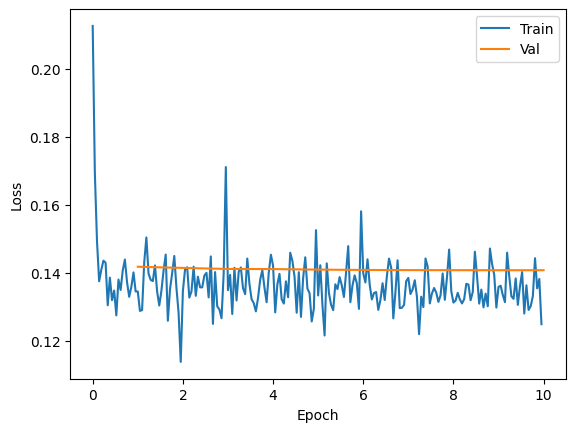

In [45]:
n_train = len(train_loss_history)
t_train = num_epochs * np.arange(n_train) / n_train
t_val = np.arange(1, num_epochs + 1)

plt.plot(t_train, train_loss_history, label="Train")
plt.plot(t_val, val_loss_history, label="Val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [46]:
model.eval()
with torch.no_grad():
    y_val = torch.Tensor(stimulus_val)
    y_val = y_val.to(device)
    spikes_pred = model(y_val)
    spikes_pred = np.array(spikes_pred.cpu())

Text(0.5, 1.0, 'EV using a data-driven approach')

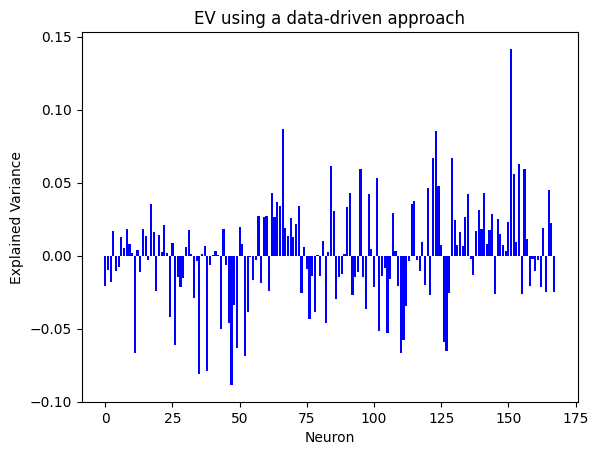

In [47]:
correlation_scores = []
explained_variance_scores = []

for i in range(spikes_val.shape[1]):
    # Correlation
    corr = np.corrcoef(spikes_val[:, i], spikes_pred[:, i])[0, 1]
    correlation_scores.append(corr)

    # Explained variance
    explained_variance = explained_variance_score(spikes_val[:, i], spikes_pred[:, i])
    explained_variance_scores.append(explained_variance)

plt.bar(range(spikes_val.shape[1]), explained_variance_scores, color='blue')
plt.xlabel('Neuron')
plt.ylabel('Explained Variance')
plt.title('EV using a data-driven approach')

In [48]:
print(f'Mean EV: {np.mean(explained_variance_scores)}')

0.0012135026710374014

Text(0.5, 1.0, 'Correlation using a data-driven approach')

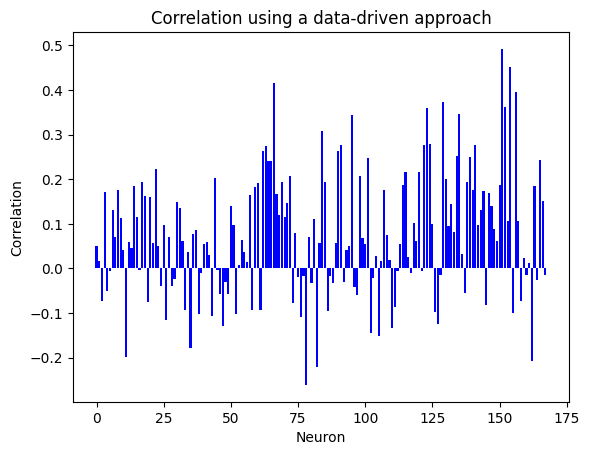

In [49]:
plt.bar(range(spikes_val.shape[1]), correlation_scores, color='blue')
plt.xlabel('Neuron')
plt.ylabel('Correlation')
plt.title('Correlation using a data-driven approach')

In [50]:
print(f'Mean correlation: {np.mean(correlation_scores)}')

0.07699890272736731